In [1]:
!pip install folium pandas openpyxl geopy


Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from geopy.geocoders import Nominatim
import time

In [3]:
def load_and_process_pincode_data(file_path):
    try:
        # Read the Excel file
        df = pd.read_excel(file_path)
        
        # Ensure column names are correctly recognized
        # Convert column names to string and strip whitespace
        df.columns = [str(col).strip() for col in df.columns]
        
        # Check if the expected pincode column exists
        if 'pincode' not in df.columns:
            # Try to find alternative column names
            pincode_alternatives = ['pincode', 'PINCODE', 'Pincode', 'PIN', 'pin', 'Pin Code', 'PIN CODE']
            
            # Find matching column
            pincode_col = None
            for alt in pincode_alternatives:
                if alt in df.columns:
                    pincode_col = alt
                    break
            
            # Rename column if found
            if pincode_col:
                df.rename(columns={pincode_col: 'pincode'}, inplace=True)
            else:
                # If no pincode column found, use the first column
                df.rename(columns={df.columns[0]: 'pincode'}, inplace=True)
        
        # Ensure pincode is treated as string
        df['pincode'] = df['pincode'].astype(str)
        
        # Count occurrences of each pincode
        pincode_counts = df['pincode'].value_counts().reset_index()
        pincode_counts.columns = ['pincode', 'count']
        
        return pincode_counts
    
    except Exception as e:
        print(f"Error loading file: {e}")
        return None

# Load your Excel file
df = load_and_process_pincode_data('bubbleplot_EMP.xlsx')

# Display the processed data
if df is not None:
    print(df.head())
else:
    print("Failed to load data. Please check your file.")


  pincode  count
0  560068     23
1  560076     17
2  560025     16
3  560066     15
4  560078     13


In [4]:
def geocode_pincodes(df, country='India'):
    """
    Convert pincodes to latitude and longitude using Nominatim
    Args:
        df: DataFrame with a 'pincode' column
        country: Country to use for geocoding (default: India)
    Returns:
        DataFrame with 'latitude' and 'longitude' columns added
    """
    # Initialize geocoder
    geolocator = Nominatim(user_agent="pincode_mapper")
    
    # Create empty columns for latitude and longitude
    df['latitude'] = None
    df['longitude'] = None
    
    # Geocode each pincode
    for idx, row in df.iterrows():
        pincode = row['pincode']
        try:
            # Query with pincode and country
            query = f"{pincode}, {country}"
            location = geolocator.geocode(query)
            
            if location:
                df.at[idx, 'latitude'] = location.latitude
                df.at[idx, 'longitude'] = location.longitude
                print(f"Geocoded {pincode}: {location.latitude}, {location.longitude}")
            else:
                print(f"Could not geocode {pincode}")
            
            # Sleep to avoid hitting API limits
            time.sleep(1)
        except Exception as e:
            print(f"Error geocoding {pincode}: {e}")
            time.sleep(1)
            continue
    
    # Drop rows with missing coordinates
    df_clean = df.dropna(subset=['latitude', 'longitude'])
    print(f"Successfully geocoded {len(df_clean)} out of {len(df)} pincodes")
    
    return df_clean

# Geocode the pincodes
# Note: This may take time depending on the number of pincodes
geocoded_df = geocode_pincodes(df)

# Show the geocoded data
geocoded_df.head()


Geocoded 560068: 12.8986856, 77.63657871843411
Geocoded 560076: 12.8826231, 77.6040474819001
Geocoded 560025: 12.963021000000001, 77.60357145087298
Geocoded 560066: 12.96684925, 77.75164275408477
Geocoded 560078: 12.89688445, 77.58255091382298
Geocoded 560027: 12.961163086021505, 77.58623299892473
Geocoded 560037: 12.9623272, 77.6972859093634
Geocoded 560035: 12.89793005, 77.70092991846323
Geocoded 560100: 12.8502428, 77.6545244022015
Geocoded 560067: 12.9455662, 77.82131801897232
Geocoded 560102: 12.91437835, 77.64325647698988
Geocoded 560087: 12.92446915, 77.72919469986229
Geocoded 560048: 12.98904855, 77.70673151352824
Geocoded 560034: 12.9255706, 77.6343792992431
Geocoded 560085: 12.93047605, 77.54532588798457
Geocoded 560016: 13.01969, 77.67737742671628
Geocoded 560017: 12.954811150000001, 77.66063780143375
Geocoded 560061: 12.90416415, 77.53994904955654
Geocoded 560036: 13.016153150000001, 77.69816482402385
Geocoded 560077: 13.060806249999999, 77.65483324435313
Geocoded 560103: 1

,pincode,count,latitude,longitude
0,560068,23,12.898686,77.636579
1,560076,17,12.882623,77.604047
2,560025,16,12.963021,77.603571
3,560066,15,12.966849,77.751643
4,560078,13,12.896884,77.582551


In [5]:
def create_folium_map(df, tiles='OpenStreetMap'):
    """
    Create a Folium bubble map with the geocoded pincode data
    Args:
        df: DataFrame with 'latitude', 'longitude', 'pincode', and 'count' columns
        tiles: Map tile style (default: 'OpenStreetMap')
    Returns:
        Folium map object
    """
    # Calculate the center of the map
    center_lat = df['latitude'].mean()
    center_lon = df['longitude'].mean()
    
    # Create a map with specified tile style
    m = folium.Map(location=[center_lat, center_lon], 
                  zoom_start=11, 
                  tiles=tiles)
    
    # Add a marker cluster for better performance with many points
    marker_cluster = MarkerCluster().add_to(m)
    
    # Calculate the max count for scaling
    max_count = df['count'].max()
    
    # Add markers for each pincode
    for idx, row in df.iterrows():
        # Calculate bubble size based on count (scaled)
        bubble_radius = min(50, max(5, row['count'] / max_count * 30))
        
        # Determine color intensity based on count
        # Higher counts get more intense colors
        color_intensity = min(0.9, max(0.2, row['count'] / max_count))
        
        # Create a circle marker
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=bubble_radius,
            popup=f"<b>Pincode:</b> {row['pincode']}<br>"
                  f"<b>Count:</b> {row['count']}",
            tooltip=f"Pincode: {row['pincode']}",
            fill=True,
            fill_opacity=color_intensity,
            color='blue',
            fill_color='blue',
            weight=2
        ).add_to(marker_cluster)
    
    # Add a legend (as a simple HTML snippet)
    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; right: 50px; width: 150px; height: 90px; 
                border:2px solid grey; z-index:9999; font-size:14px;
                background-color:white;
                padding: 10px;
                border-radius: 5px;
                ">
      <span style="font-weight: bold;">Pincode Count</span><br>
      <i class="fa fa-circle" style="color:blue; opacity:0.9;"></i> High<br>
      <i class="fa fa-circle" style="color:blue; opacity:0.5;"></i> Medium<br>
      <i class="fa fa-circle" style="color:blue; opacity:0.2;"></i> Low
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    # Add layer control
    folium.LayerControl().add_to(m)
    
    return m

# Create the Folium map with default OpenStreetMap tiles
folium_map = create_folium_map(geocoded_df)

# Display the map
folium_map


In [6]:
dark_map = create_folium_map(geocoded_df, tiles='cartodbdark_matter')

# Display the dark map
dark_map

In [7]:
# Cell 7: Save the maps to HTML files
folium_map.save('pincode_bubble_map_light.html')
dark_map.save('pincode_bubble_map_dark.html')
print("Maps saved as HTML files:")
print("- pincode_bubble_map_light.html")
print("- pincode_bubble_map_dark.html")

Maps saved as HTML files:
- pincode_bubble_map_light.html
- pincode_bubble_map_dark.html


In [8]:
# Cell 8: Add reference points and cluster pincodes around specific locations
def add_reference_points_and_cluster(map_obj, geocoded_df):
    """
    Add specific reference points to the map and cluster pincodes around them
    
    Args:
        map_obj: Folium map object
        geocoded_df: DataFrame with geocoded pincodes
    
    Returns:
        Updated Folium map object
    """
    import math
    
    # Define the three reference locations with updated coordinates
    reference_points = [
        {"name": "Divyasree", "lat": 12.962537, "lng": 77.600343},
        {"name": "Umiya City", "lat": 13.052477, "lng": 77.594383},
        {"name": "White Field", "lat": 12.970818, "lng": 77.749787}
    ]
    
    # Add reference points to the map with distinctive markers
    for point in reference_points:
        # Add a marker for each reference point
        folium.Marker(
            location=[point["lat"], point["lng"]],
            popup=f"<b>{point['name']}</b>",
            tooltip=point["name"],
            icon=folium.Icon(color='red', icon='star', prefix='fa')
        ).add_to(map_obj)
        
        # Add a circle around each reference point to show the area
        folium.Circle(
            location=[point["lat"], point["lng"]],
            radius=5000,  # 5km radius
            color='red',
            fill=True,
            fill_opacity=0.1,
            popup=f"{point['name']} Area"
        ).add_to(map_obj)
    
    # Calculate distances from each pincode to each reference point
    # and assign pincodes to the closest reference point
    clusters = {point["name"]: [] for point in reference_points}
    
    for idx, row in geocoded_df.iterrows():
        # Calculate distance to each reference point
        distances = []
        for point in reference_points:
            # Calculate distance in kilometers (using Haversine formula)
            lat1, lon1 = row['latitude'], row['longitude']
            lat2, lon2 = point["lat"], point["lng"]
            R = 6371  # Earth radius in kilometers
            dLat = (lat2 - lat1) * (math.pi/180)
            dLon = (lon2 - lon1) * (math.pi/180)
            a = (
                math.sin(dLat/2) * math.sin(dLat/2) +
                math.cos(lat1 * (math.pi/180)) * math.cos(lat2 * (math.pi/180)) *
                math.sin(dLon/2) * math.sin(dLon/2)
            )
            c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
            distance = R * c
            distances.append((point["name"], distance))
        
        # Find the closest reference point
        closest_point = min(distances, key=lambda x: x[1])
        
        # Store the distances for this pincode
        row_with_distances = row.copy()
        row_with_distances['distances'] = {pt[0]: round(pt[1], 2) for pt in distances}
        row_with_distances['closest_point'] = closest_point[0]
        
        # Add to the appropriate cluster
        clusters[closest_point[0]].append(row_with_distances)
    
    # Create cluster layers
    for point_name, cluster_rows in clusters.items():
        if not cluster_rows:
            continue
            
        # Create a feature group for this cluster
        cluster_group = folium.FeatureGroup(name=f"{point_name} Cluster")
        
        # Add pincodes to this cluster
        for row in cluster_rows:
            # Calculate bubble size based on count
            bubble_radius = min(50, max(5, row['count'] / geocoded_df['count'].max() * 30))
            
            # Determine color based on reference point
            color = 'blue'
            if point_name == "Divyasree":
                color = 'green'
            elif point_name == "Umiya City":
                color = 'purple'
            elif point_name == "White Field":
                color = 'orange'
            
            # Create a tooltip with frequency and distances
            tooltip_html = f"Pincode: {row['pincode']}<br>Frequency: {row['count']}<br>"
            tooltip_html += "<br>Distances:<br>"
            for ref_name, distance in row['distances'].items():
                tooltip_html += f"- {ref_name}: {distance} km<br>"
            
            # Create a circle marker
            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                radius=bubble_radius,
                popup=f"<b>Pincode:</b> {row['pincode']}<br>"
                      f"<b>Count:</b> {row['count']}<br>"
                      f"<b>Cluster:</b> {point_name}",
                tooltip=tooltip_html,
                fill=True,
                fill_opacity=0.7,
                color=color,
                fill_color=color
            ).add_to(cluster_group)
        
        # Add the cluster group to the map
        cluster_group.add_to(map_obj)
    
    # Add layer control if it doesn't exist
    if not any(isinstance(child, folium.LayerControl) for child in map_obj._children.values()):
        folium.LayerControl().add_to(map_obj)
    
    return map_obj

# Create a new map with reference points and clusters
clustered_map = folium.Map(
    location=[12.9716, 77.6946],  # Center around Bangalore
    zoom_start=11
)

# Add reference points and clusters
clustered_map = add_reference_points_and_cluster(clustered_map, geocoded_df)

# Display the clustered map
clustered_map

In [9]:
# Save the clustered map
clustered_map.save('pincode_clusters_map.html')
print("Clustered map saved as 'pincode_clusters_map.html'")

Clustered map saved as 'pincode_clusters_map.html'


Cluster Statistics:
       cluster  total_pincodes  total_count  avg_count  min_count  max_count
0    Divyasree              44          196   4.454545          1         23
1   Umiya City              25           38   1.520000          1          4
2  White Field              16           91   5.687500          1         15


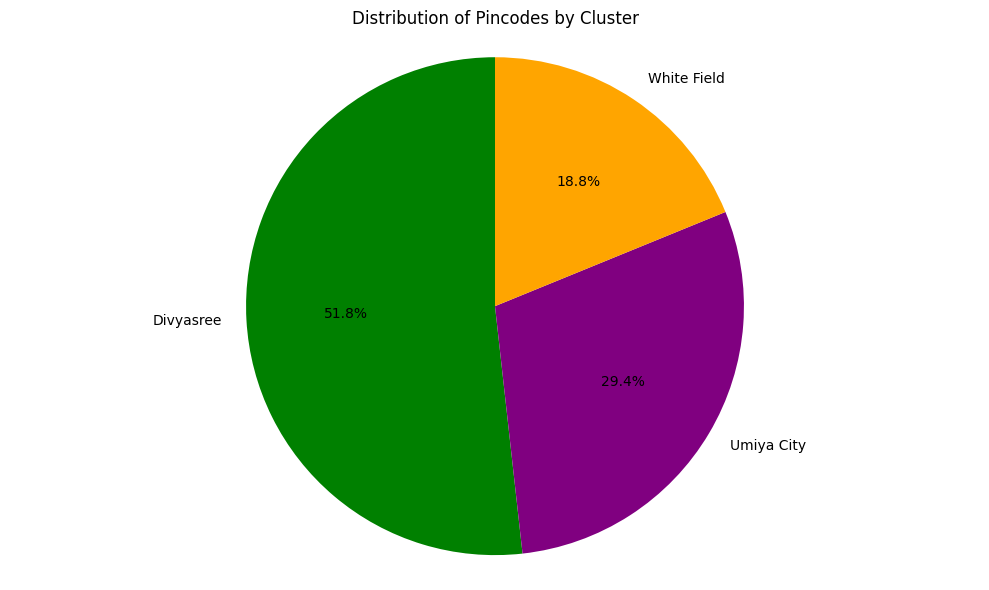

In [10]:
def calculate_cluster_statistics(geocoded_df):
    """
    Calculate statistics for each cluster of pincodes
    
    Args:
        geocoded_df: DataFrame with geocoded pincodes
    
    Returns:
        DataFrame with cluster statistics
    """
    # Define the three reference locations
    reference_points = [
        {"name": "Divyasree", "lat": 12.962537, "lng": 77.600343},
        {"name": "Umiya City", "lat": 13.052477, "lng": 77.594383},
        {"name": "White Field", "lat": 12.970818, "lng": 77.749787}
    ]
    
    # Add a column for the assigned cluster
    geocoded_df['cluster'] = None
    
    # Assign each pincode to the closest reference point
    for idx, row in geocoded_df.iterrows():
        # Calculate distance to each reference point
        distances = []
        for point in reference_points:
            # Simple Euclidean distance
            dist = ((row['latitude'] - point["lat"])**2 + (row['longitude'] - point["lng"])**2)**0.5
            distances.append((point["name"], dist))
        
        # Find the closest reference point
        closest_point = min(distances, key=lambda x: x[1])
        
        # Assign to cluster
        geocoded_df.at[idx, 'cluster'] = closest_point[0]
    
    # Calculate statistics for each cluster
    cluster_stats = geocoded_df.groupby('cluster').agg(
        total_pincodes=('pincode', 'count'),
        total_count=('count', 'sum'),
        avg_count=('count', 'mean'),
        min_count=('count', 'min'),
        max_count=('count', 'max')
    ).reset_index()
    
    print("Cluster Statistics:")
    print(cluster_stats)
    
    # Create a pie chart of pincode distribution using matplotlib
    import matplotlib.pyplot as plt
    
    # Count pincodes in each cluster
    cluster_counts = geocoded_df.groupby('cluster').size()
    
    # Create pie chart
    plt.figure(figsize=(10, 6))
    plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=90, 
            colors=['green', 'purple', 'orange'])
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.title('Distribution of Pincodes by Cluster')
    plt.tight_layout()
    plt.show()
    
    return cluster_stats

cluster_stats = calculate_cluster_statistics(geocoded_df)

In [12]:
# Cell 12: Map Employee ADID to Closest Reference Point
def map_employees_to_closest_reference_point(employee_file_path, geocoded_pincodes_df):
    """
    Maps each employee to their closest reference point based on their pincode
    
    Args:
        employee_file_path: Path to Excel file with Employee Code/ADID and Pincode
        geocoded_pincodes_df: DataFrame with geocoded pincodes
    
    Returns:
        DataFrame with employee mapping and saves to Excel
    """
    import math
    import pandas as pd
    
    # Define reference points
    reference_points = [
        {"name": "Divyasree", "lat": 12.962537, "lng": 77.600343},
        {"name": "Umiya City", "lat": 13.052477, "lng": 77.594383},
        {"name": "White Field", "lat": 12.970818, "lng": 77.749787}
    ]
    
    # Read employee data
    try:
        # Try to read with standard column names
        employees_df = pd.read_excel(employee_file_path)
        
        # Check column names and standardize if needed
        if 'Employee Code / ADID' in employees_df.columns:
            employees_df.rename(columns={'Employee Code / ADID': 'ADID'}, inplace=True)
        elif 'Employee Code' in employees_df.columns:
            employees_df.rename(columns={'Employee Code': 'ADID'}, inplace=True)
        elif 'ADID' in employees_df.columns:
            pass  # Already has the right name
        else:
            # If no matching column, assume first column is ADID
            employees_df.rename(columns={employees_df.columns[0]: 'ADID'}, inplace=True)
            
        # Ensure 'Pincode' column exists
        if 'Pincode' not in employees_df.columns and 'pincode' not in employees_df.columns:
            # If no pincode column, assume second column is Pincode
            employees_df.rename(columns={employees_df.columns[1]: 'Pincode'}, inplace=True)
        elif 'pincode' in employees_df.columns:
            employees_df.rename(columns={'pincode': 'Pincode'}, inplace=True)
        
        # Convert ADID to string and uppercase for consistency
        employees_df['ADID'] = employees_df['ADID'].astype(str).str.upper()
        
        # Convert Pincode to string
        employees_df['Pincode'] = employees_df['Pincode'].astype(str)
        
        print(f"Loaded {len(employees_df)} employees")
        
    except Exception as e:
        print(f"Error loading employee file: {e}")
        return None
    
    # Add columns for assigned location and distances
    employees_df['Assigned_Location'] = None
    employees_df['Distance_km'] = None
    employees_df['Distance_to_Divyasree_km'] = None
    employees_df['Distance_to_Umiya_City_km'] = None
    employees_df['Distance_to_White_Field_km'] = None
    
    # Process each employee
    for idx, employee in employees_df.iterrows():
        employee_pincode = employee['Pincode']
        
        # Find this pincode in the geocoded data
        pincode_data = geocoded_pincodes_df[geocoded_pincodes_df['pincode'] == employee_pincode]
        
        if len(pincode_data) > 0:
            # Get the first matching pincode's coordinates
            lat = pincode_data.iloc[0]['latitude']
            lng = pincode_data.iloc[0]['longitude']
            
            # Calculate distance to each reference point
            distances = []
            for point in reference_points:
                # Calculate distance in kilometers (using Haversine formula)
                lat1, lon1 = lat, lng
                lat2, lon2 = point["lat"], point["lng"]
                R = 6371  # Earth radius in kilometers
                dLat = (lat2 - lat1) * (math.pi/180)
                dLon = (lon2 - lon1) * (math.pi/180)
                a = (
                    math.sin(dLat/2) * math.sin(dLat/2) +
                    math.cos(lat1 * (math.pi/180)) * math.cos(lat2 * (math.pi/180)) *
                    math.sin(dLon/2) * math.sin(dLon/2)
                )
                c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
                distance = R * c
                distances.append((point["name"], distance))
                
                # Store individual distances
                if point["name"] == "Divyasree":
                    employees_df.at[idx, 'Distance_to_Divyasree_km'] = round(distance, 2)
                elif point["name"] == "Umiya City":
                    employees_df.at[idx, 'Distance_to_Umiya_City_km'] = round(distance, 2)
                elif point["name"] == "White Field":
                    employees_df.at[idx, 'Distance_to_White_Field_km'] = round(distance, 2)
            
            # Find the closest reference point
            closest_point = min(distances, key=lambda x: x[1])
            
            # Assign the employee to the closest location
            employees_df.at[idx, 'Assigned_Location'] = closest_point[0]
            employees_df.at[idx, 'Distance_km'] = round(closest_point[1], 2)
            
        else:
            print(f"Warning: Pincode {employee_pincode} for ADID {employee['ADID']} not found in geocoded data")
            # Mark as unassigned
            employees_df.at[idx, 'Assigned_Location'] = "Unassigned"
    
    # Save the results to Excel
    output_file = 'employee_location_assignments.xlsx'
    employees_df.to_excel(output_file, index=False)
    print(f"Saved employee assignments to {output_file}")
    
    # Generate summary statistics
    location_counts = employees_df['Assigned_Location'].value_counts()
    print("\nAssignment Summary:")
    for location, count in location_counts.items():
        print(f"{location}: {count} employees")
    
    return employees_df

employee_assignments = map_employees_to_closest_reference_point(
    'bubbleplot_EMP.xlsx',  # Replace with your employee data file path
    geocoded_df
)

Loaded 325 employees
Saved employee assignments to employee_location_assignments.xlsx

Assignment Summary:
Divyasree: 196 employees
White Field: 90 employees
Umiya City: 39 employees
